# Test on Velodyne data

In [1]:
%matplotlib widget
import numpy as np
import os
import time

from planeslam.general import plot_3D_setup, downsample
from planeslam.mesh import LidarMesh
from planeslam.scan import Scan
from planeslam.clustering import cluster_mesh_graph_search, mesh_cluster_pts
from planeslam.extraction import scan_from_clusters

%load_ext autoreload
%autoreload 2

Load data

In [2]:
# Read in point cloud data
pcpath = os.path.join(os.getcwd(),'..', 'data', 'velodyne', '6_7_2022', 'durand_3rd_floor', 'run_1')

In [9]:
# PCs = []
# for i in range(len(os.listdir(pcpath))):
#     filename = pcpath+'/pc_'+str(i)+'.npy'
#     PC = np.load(filename)
#     PCs.append(PC)

frame = 2000
filename = pcpath+'/pc_'+str(frame)+'.npy'
PC = np.load(filename)

In [7]:
# Downsample
PC = downsample(PC, factor=5, axis=0)

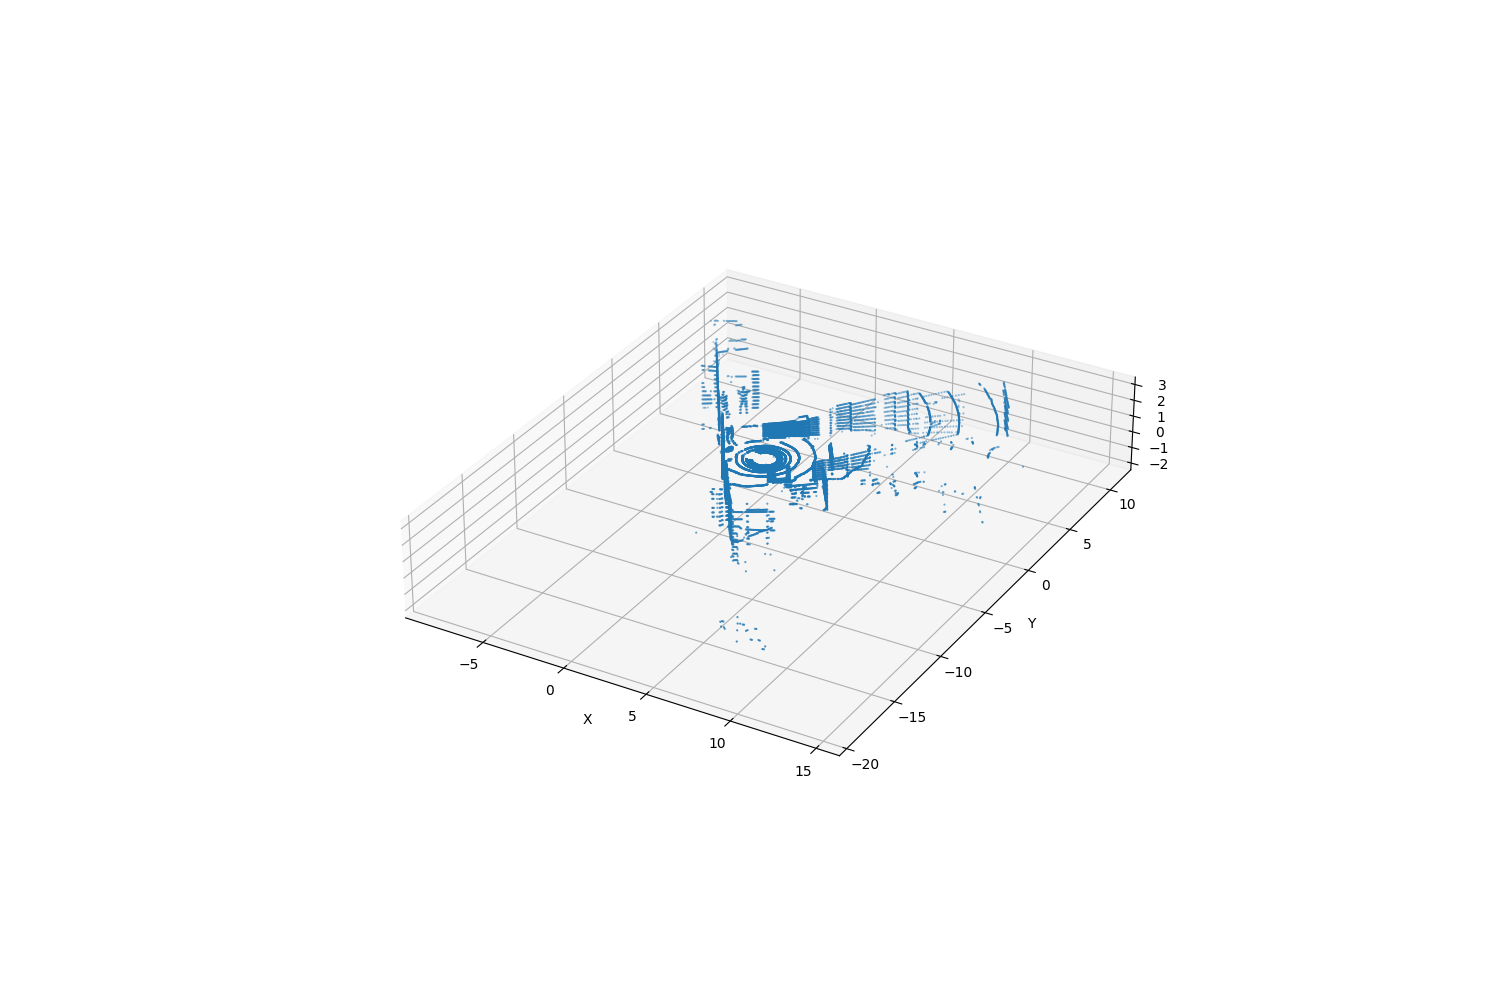

In [10]:
ax = plot_3D_setup(PC, figsize=(15,10))
ax.scatter3D(PC[:,0], PC[:,1], PC[:,2], marker='.', s=1)  

Cluster

In [17]:
# Create the mesh
mesh = LidarMesh(PC)
mesh.prune(edge_len_lim=5)
start_time = time.time()
# Cluster the mesh with graph search
clusters, avg_normals = cluster_mesh_graph_search(mesh)
print("elapsed time: ", time.time() - start_time)

elapsed time:  0.9855794906616211


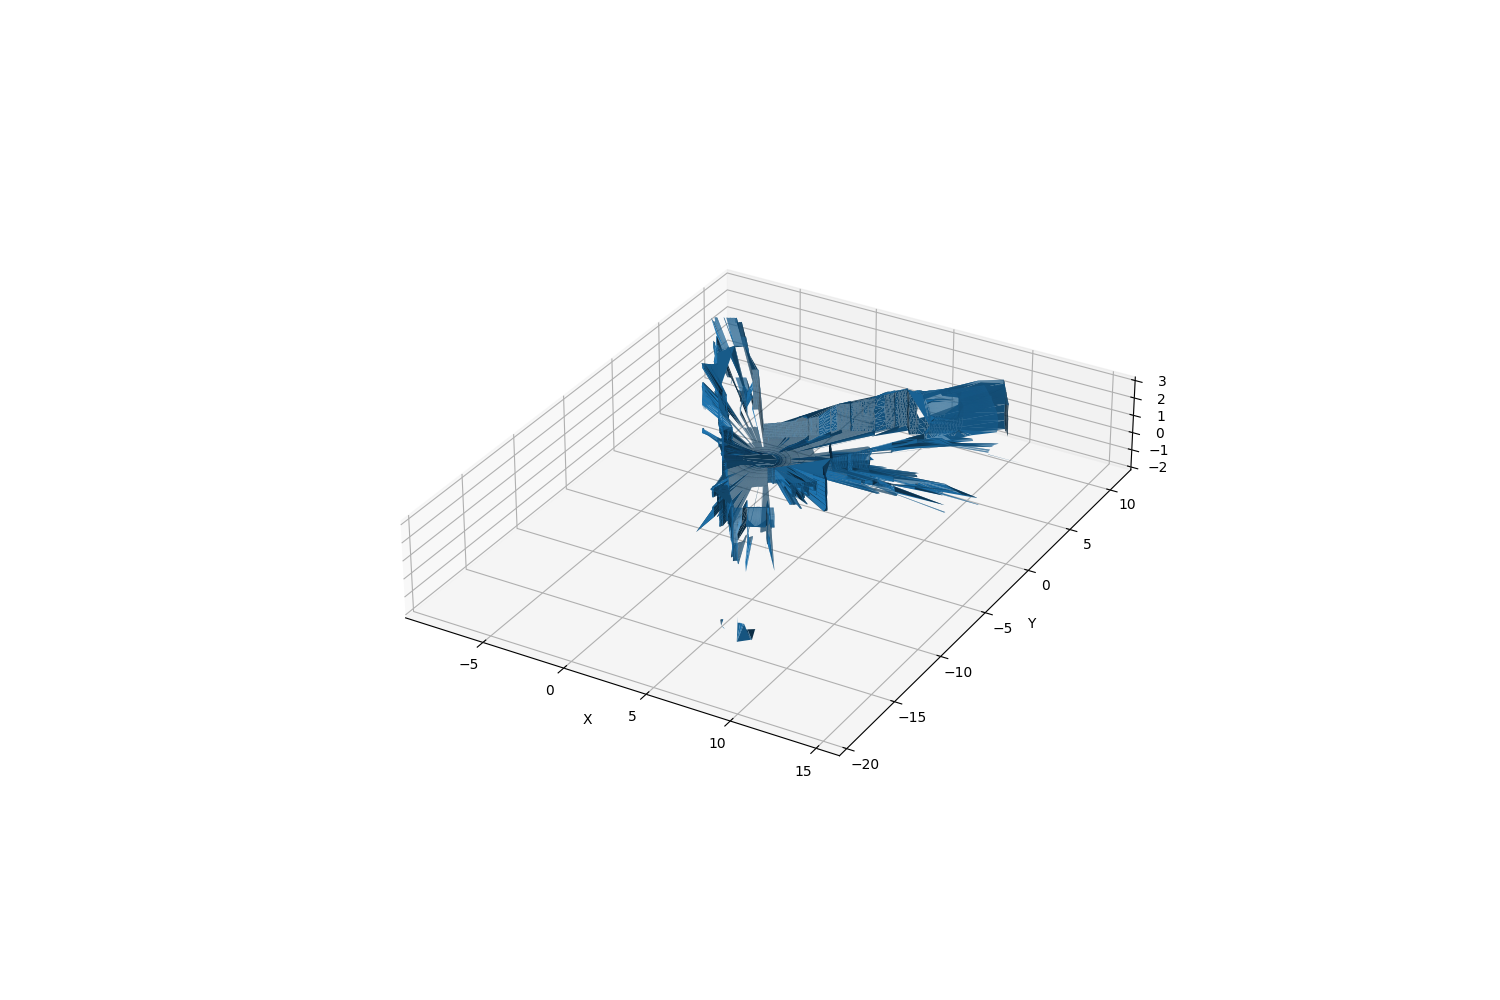

In [18]:
# Plot mesh
ax = plot_3D_setup(PC, figsize=(15,10))
ax.plot_trisurf(PC[:,0], PC[:,1], PC[:,2], triangles=mesh.DT.simplices)

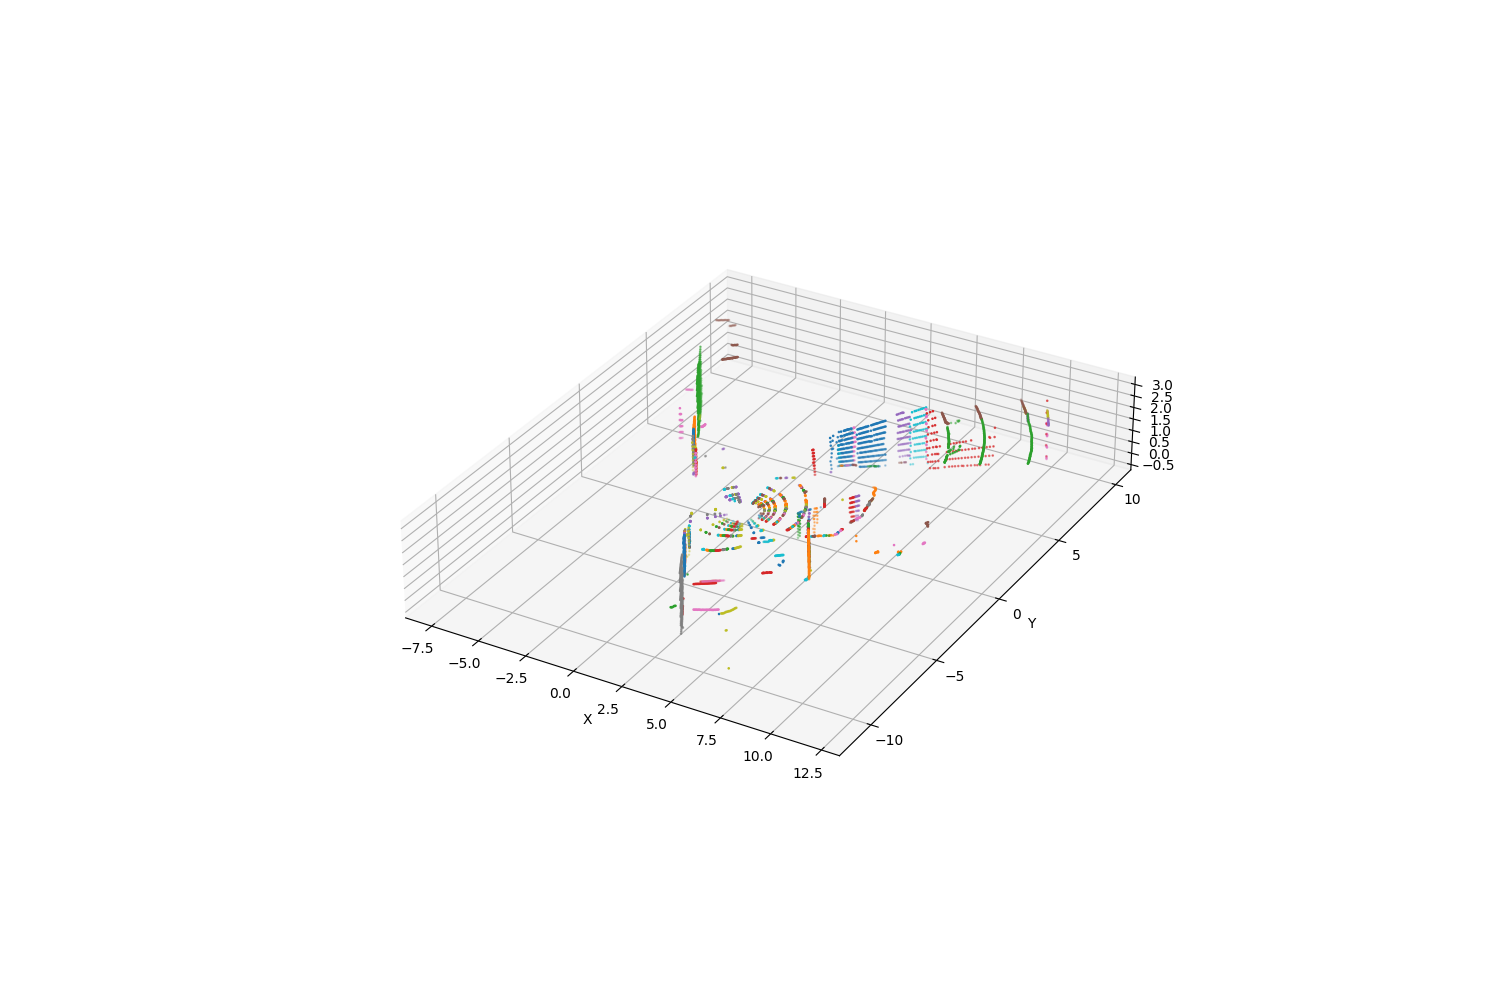

In [19]:
# Plot clusters
ax = plot_3D_setup(PC)

for i, c in enumerate(clusters):
    cluster_pts = mesh_cluster_pts(mesh, c)
    ax.scatter3D(cluster_pts[:,0], cluster_pts[:,1], cluster_pts[:,2], color='C'+str(i), marker='.', s=3)

Extract planes

In [8]:
planes, vertices, faces = scan_from_clusters(mesh, clusters, avg_normals)
scan = Scan(planes, vertices, faces)

[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask
[ True False  True False] , is not a valid mask
[False  True False  True] , is not a valid mask
[ True False  True False] , is not a valid mask
[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask
[ True False  True False] , is not a valid mask
[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask
[ True False  True False] , is not a valid mask
[False  True False  True] , is not a valid mask
[False  True False  True] , is not a valid mask


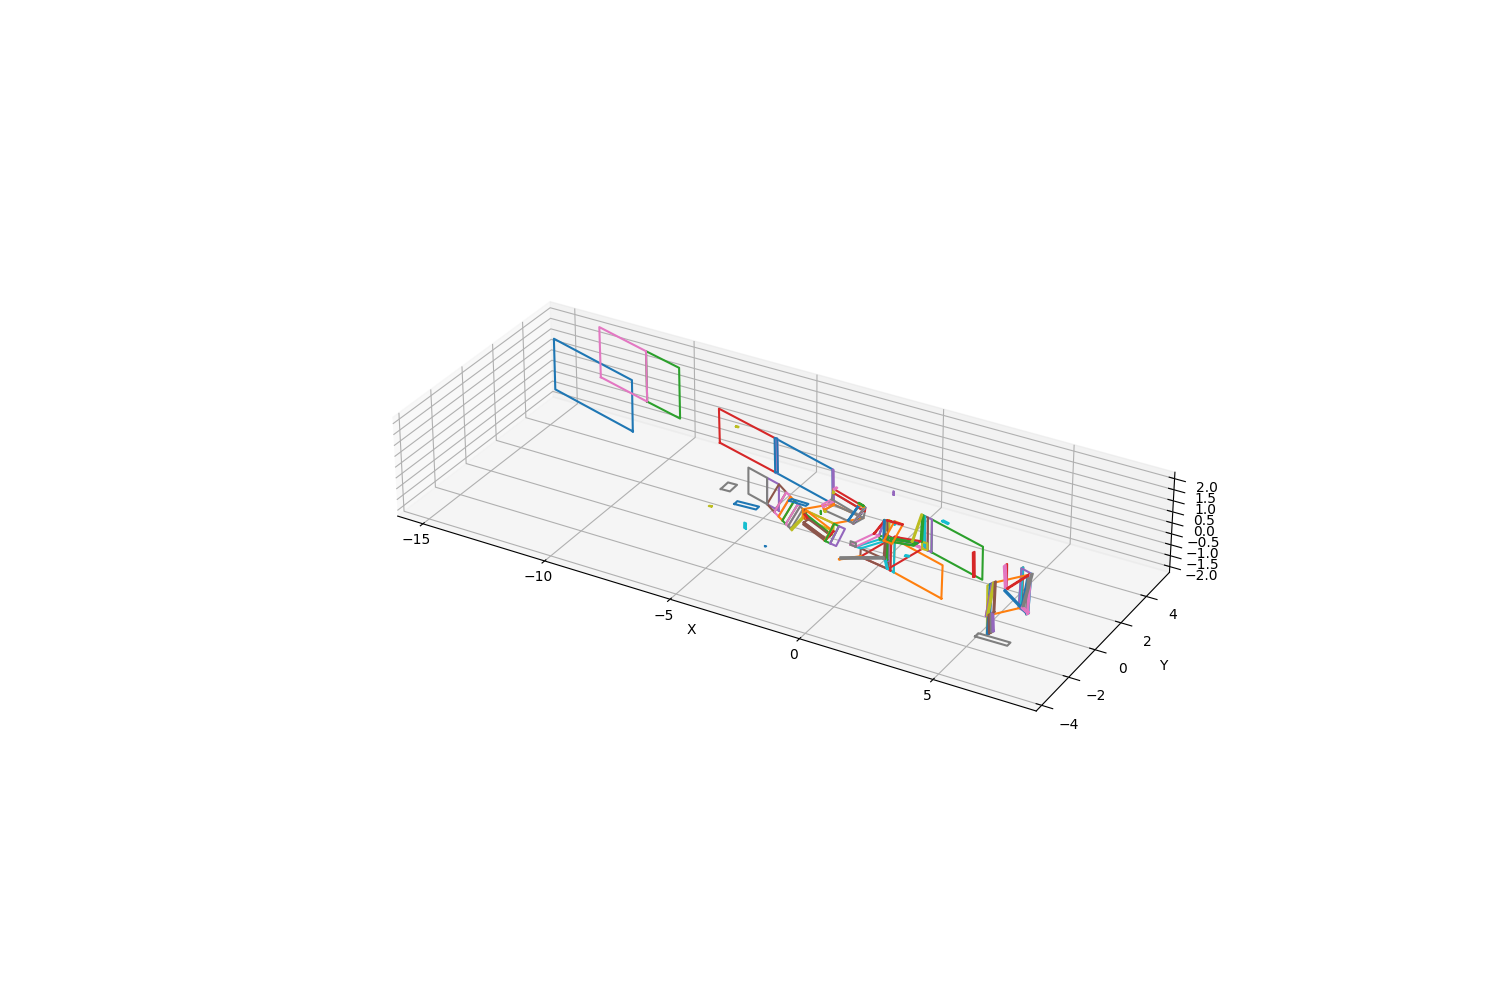

In [9]:
ax = plot_3D_setup(PC)
scan.plot(ax, show_normals=False)